# Практическое задание. Прогнозирование временных рядов

Исходные данные: датасет с данными о годовой величине ВВП Ганы. 

In [555]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

%matplotlib inline

# Часть 1

In [556]:
# Загрузка исходного датасета
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=['year'], index_col=['year'])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


<AxesSubplot:title={'center':'Исходный датасет'}, xlabel='year'>

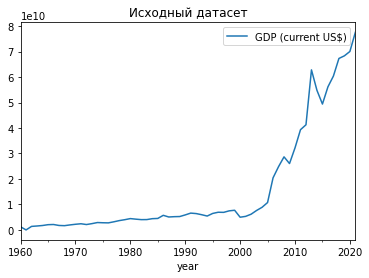

In [557]:
# Построение графика
data.plot(title='Исходный датасет')

In [558]:
# Разделение на тренировочную и тестовую выборку
train_df = data[:'2018-01-01']
test_df = data['2019-01-01':]

In [559]:
# Функция для построения прогноза по скользящей средней
def moving_averege(series, n):
    """
    Forecasting function by moving averege

    Args:
        series (DataFrame): dataframe with timeseries
        n (int): rolling window size

    Returns:
        float: Forecast
    """
    return np.average(series[-n:])


# Отображение прогноза по последним трем значениям тренировочной выборки
display(moving_averege(train_df, 3))
# Отображение действительного значения из тестовой выборки
display(test_df.iloc[0].values[0])

61290278825.64996

68337537815.7703

In [560]:
# Функция для построения графиков скользящего среднего
def plotMovingAverage(series, n):
    """
    Making plot function of moving averege

    Args:
        series (DataFrame): dataframe with timeseries
        n (int): rolling window size

    Returns:
        None: None
        
    """
    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

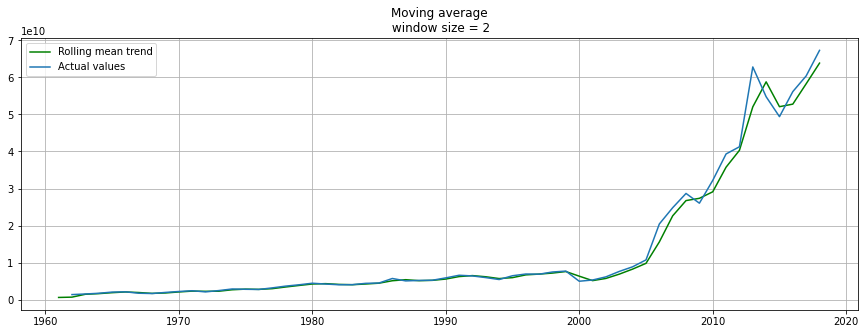

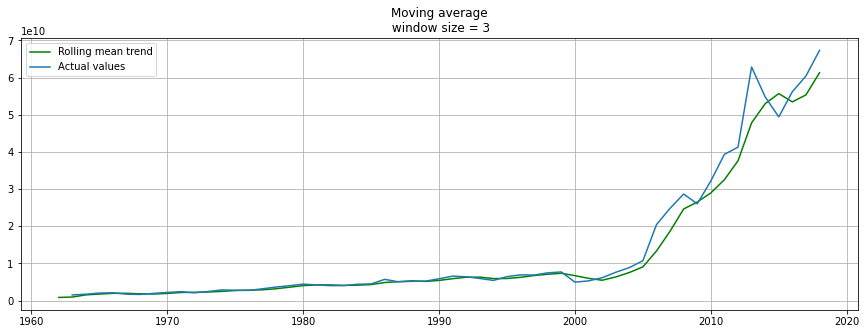

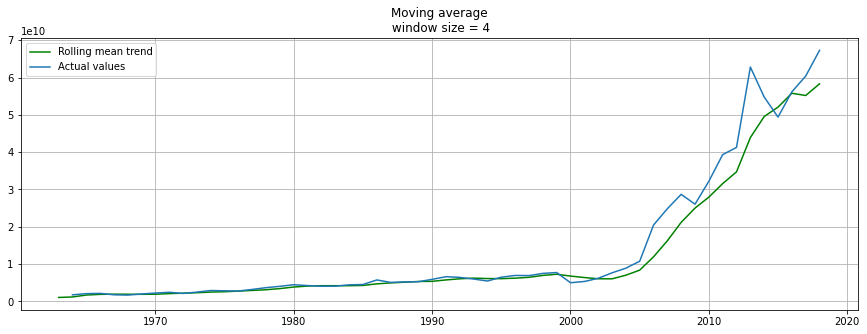

In [561]:
plotMovingAverage(train_df, 2)
plotMovingAverage(train_df, 3)
plotMovingAverage(train_df, 4)

Анализ графика: 
Построение скользящей среднее хорошо подходит для сглаживания исходного ряда и выявления тренда. Как видно по построенным графикам наблюдается четкий тренд на увеличение значения ВВП начиная с середены 2000-х годов. Оптимальным значением окна для скользящего среднего является значение равное трем.


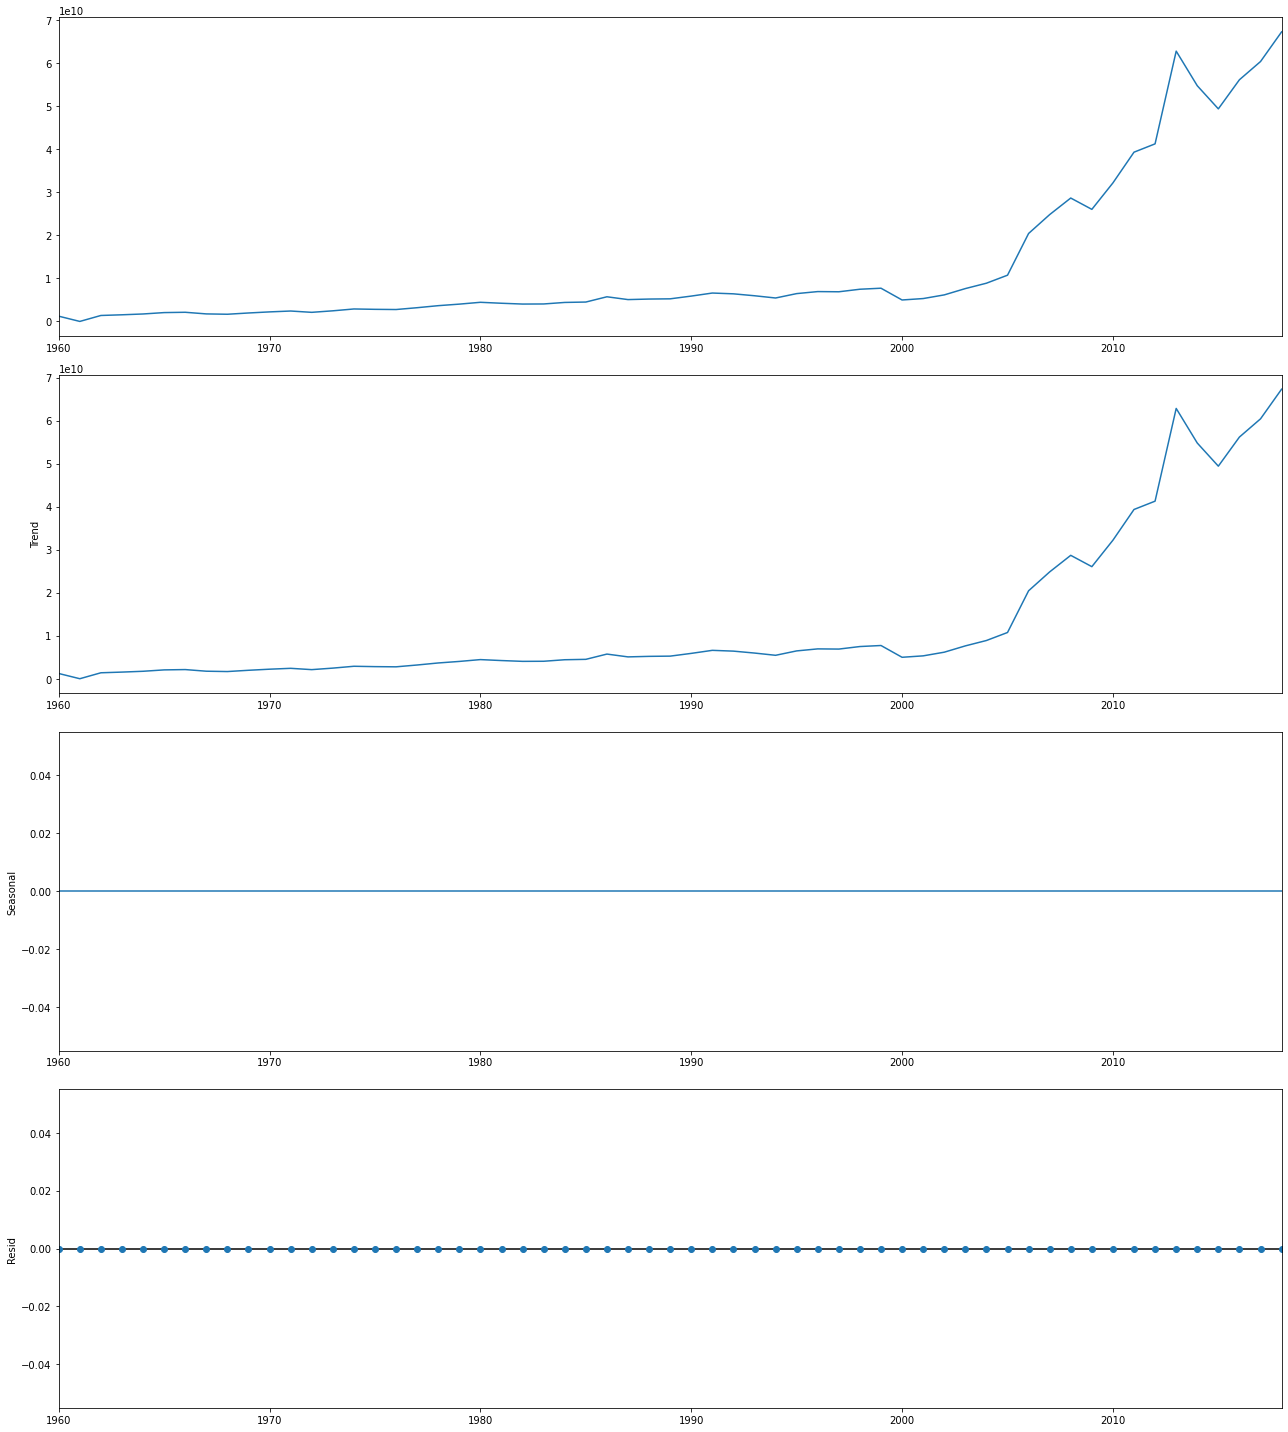

In [562]:
# Анализ сезонности
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df, model='additive')
result.plot()
plt.show()

По результатам анализа графика можно отметить наличие тренда и отсутствие сезоннсти в данных

In [563]:
# Выполнение теста на стационарность
stat_test_1 = adfuller(train_df)
print ('adf: ', stat_test_1[0])
print ('p-value: ', stat_test_1[1])
print ('Critical values: ', stat_test_1[4])
if stat_test_1[0]> stat_test_1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.6529066974885349
p-value:  0.9888496277665572
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


По результатам проведения теста сделан вывод, что ряд нестационарен. Необходимы выполнить дифференцирование ряда и в дальнейшем использовать модель ARIMA.

In [564]:
# Выполнение теста на стационарность
stat_test_2 = adfuller(train_df.diff(periods=1).dropna())
print ('adf: ', stat_test_2[0])
print ('p-value: ', stat_test_2[1])
print ('Critical values: ', stat_test_2[4])
if stat_test_2[0]> stat_test_2[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.6702483038320777
p-value:  0.446502932971389
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [565]:
# Выполнение теста на стационарность
stat_test_3 = adfuller(train_df.diff(periods=2).dropna())
print ('adf: ', stat_test_3[0])
print ('p-value: ', stat_test_3[1])
print ('Critical values: ', stat_test_3[4])
if stat_test_3[0] > stat_test_3[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -3.5836708658260297
p-value:  0.006080989753876958
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


In [566]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 20, ax = axes[0])
    sgt.plot_pacf(series, lags = 20, ax = axes[1])
    plt.show()

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


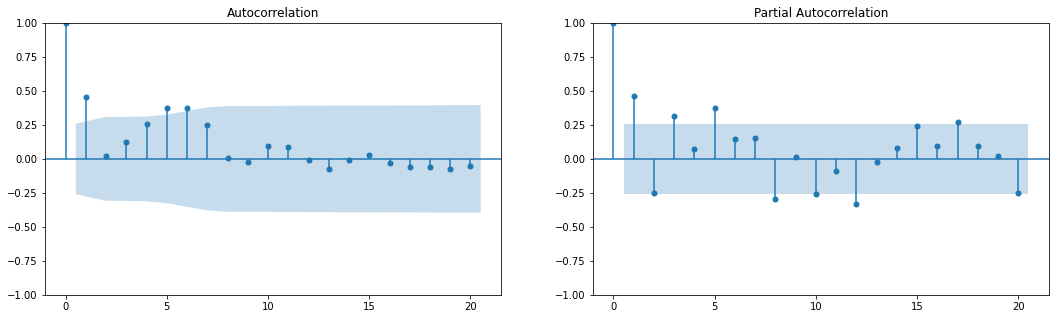

In [567]:
plot_acf_pacf(train_df.diff(periods=2).dropna())

По графикам можно сделать вывод о необходимости выбора параметров p и q равными 5 и 1 соответственно.

In [568]:
p = 1 # Последний значимый лаг по граффику частичной автокорреляции
d = 2 # По результатам тестов на стационарность
q = 1 # Последний значимый лаг по графика автокорреляции

In [569]:
arima_model = ARIMA(train_df.dropna(), order = (p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 1)   Log Likelihood               -1339.208
Date:                Fri, 25 Nov 2022   AIC                           2684.416
Time:                        11:59:32   BIC                           2690.545
Sample:                    01-01-1960   HQIC                          2686.798
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1775      0.082     -2.159      0.031      -0.339      -0.016
ma.L1         -0.8688      0.046    -19.069      0.000      -0.958      -0.780
sigma2       1.96e+19   2.13e-22    9.2e+40      0.000    1.96e+19    1.96e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):               276.42
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):             325.65   Skew:                             1.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.49e+56. Standard errors may be unstable.
"""

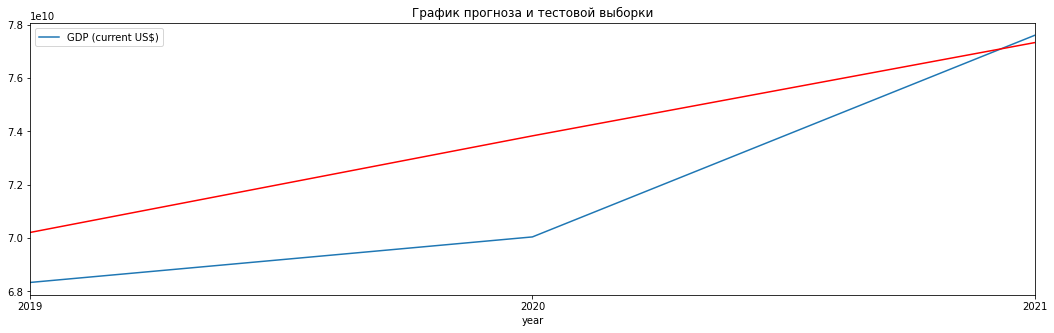

In [570]:
forecast_1 = arima_model_fit.predict(start=len(train_df), end=(len(train_df)+2), dynamic=False)

test_df.plot()
forecast_1.plot(color='red')
plt.title('График прогноза и тестовой выборки');

In [571]:
# Подбор наилучших параметров
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         #test='adf',
                         max_p=6, max_q=6, m=0,
                         start_P=1, seasonal=False,
                         d=2, D=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.339, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.886, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.594, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.662, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.959, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.054, Time=0.09 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.896, Time=0.07 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.15 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.926, Time=0.06 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.782, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.416, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2693.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 25 Nov 2022   AIC                           2680.765
Time:                        11:59:37   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [572]:
# Построение модели ARIMA с наилучшими параметрами
best_arima_model = ARIMA(train_df.dropna(), order = (1, 2, 3))
best_arima_model = best_arima_model.fit()
best_arima_model.summary()

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.382
Date:                Fri, 25 Nov 2022   AIC                           2680.765
Time:                        11:59:38   BIC                           2690.980
Sample:                    01-01-1960   HQIC                          2684.735
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5682      0.163     -3.487      0.000      -0.888      -0.249
ma.L1         -0.4241      0.235     -1.803      0.071      -0.885       0.037
ma.L2         -0.8256      0.169     -4.886      0.000      -1.157      -0.494
ma.L3          0.5193      0.137      3.790      0.000       0.251       0.788
sigma2      1.868e+19   8.55e-21   2.18e+39      0.000    1.87e+19    1.87e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               173.00
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):             141.34   Skew:                             1.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+55. Standard errors may be unstable.
"""

In [573]:
forecast_2 = best_arima_model.predict(start=len(train_df), end=(len(train_df)+2), dynamic=False)

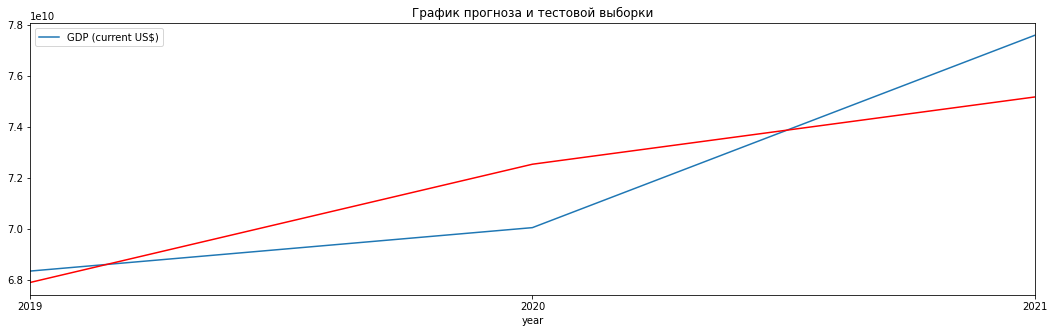

In [574]:
test_df.plot()
forecast_2.plot(color='red')
plt.title('График прогноза и тестовой выборки');

In [575]:
pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = forecast_2

pred_df["GDP (current US$)"] = data["GDP (current US$)"]

forecast = best_arima_model.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower GDP (current US$)"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper GDP (current US$)"]

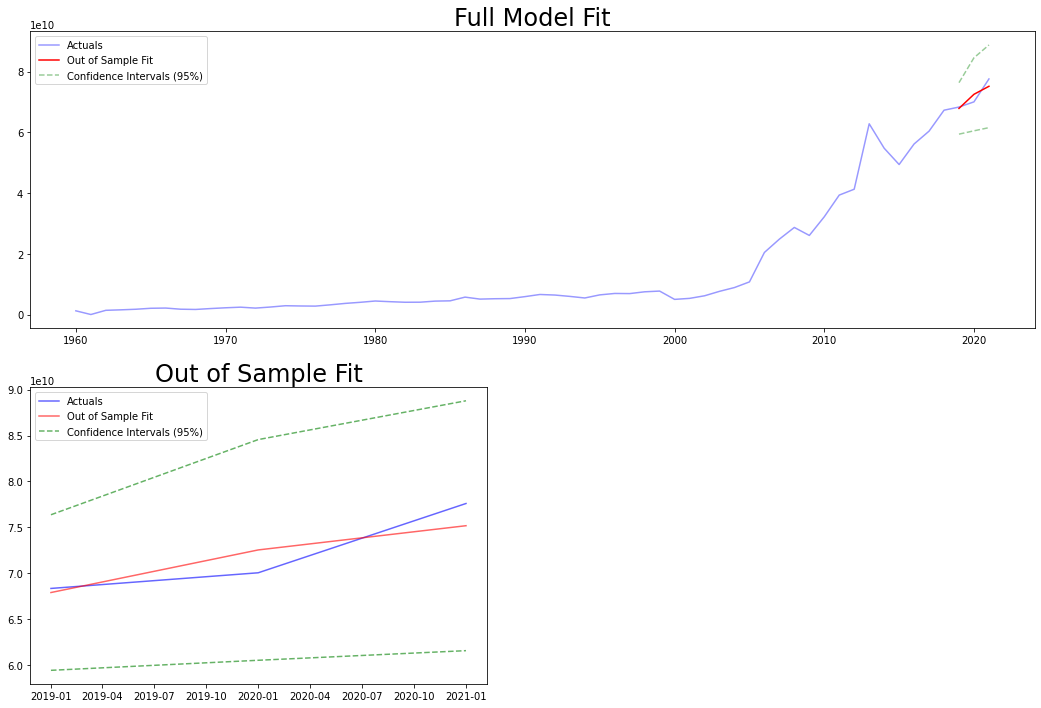

In [576]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["GDP (current US$)"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Вывод:
По результатам построения моделей ARIMA подобраны оптимальные параметры (с помощью pmdarima) p=1, d=2, q=3, показатель AIC равняется 2680.765. На основе обученной модели сделан прогноз, построен график тестовой выборки и сделанного прогноза.

# Часть 2

In [577]:
# Проверка на пропуски в датах
data.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [578]:
# Проверка на наличие пропусков
data.isna().sum()

GDP (current US$)    0
dtype: int64

In [579]:
# Замена нулевых значений на Nan
data['GDP (current US$)'] = data['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

In [580]:
# Проверка на наличие пропусков
data.isna().sum()

GDP (current US$)    1
dtype: int64

In [581]:
data['GDP (current US$)'] = data['GDP (current US$)'].interpolate(method='linear')

In [582]:
# Разделение на тренировочную и тестовую выборку
train_df = data[:'2018-01-01']
test_df = data['2019-01-01':]

In [583]:
# Выполнение теста на стационарность
stat_test_5 = adfuller(train_df)
print ('adf: ', stat_test_5[0])
print ('p-value: ', stat_test_5[1])
print ('Critical values: ', stat_test_5[4])
if stat_test_5[0]> stat_test_5[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  0.8030073326980129
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [584]:
# Выполнение теста на стационарность
stat_test_6 = adfuller(train_df.diff(periods=1).dropna())
print ('adf: ', stat_test_6[0])
print ('p-value: ', stat_test_6[1])
print ('Critical values: ', stat_test_6[4])
if stat_test_6[0]> stat_test_6[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -1.8255652246435998
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [585]:
# Выполнение теста на стационарность
stat_test_7 = adfuller(train_df.diff(periods=2).dropna())
print ('adf: ', stat_test_7[0])
print ('p-value: ', stat_test_7[1])
print ('Critical values: ', stat_test_7[4])
if stat_test_7[0]> stat_test_7[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -3.999803440949147
p-value:  0.0014115408436661371
Critical values:  {'1%': -3.584828853223594, '5%': -2.9282991495198907, '10%': -2.6023438271604937}
ряд стационарен


In [586]:
# Подбор наилучших параметров
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         #test='adf',
                         max_p=6, max_q=6, m=0,
                         start_P=1, seasonal=False,
                         d=2, D=2, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=2687.479, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=2721.621, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=2706.528, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=2687.799, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=2719.683, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=2686.221, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=2694.822, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=2687.929, Time=0.12 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=2695.861, Time=0.05 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=2683.709, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=2684.377, Time=0.04 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=2692.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   59
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 25 Nov 2022   AIC                           2680.513
Time:                        11:59:44   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

In [587]:
# Построение модели ARIMA с наилучшими параметрами
best_arima_model = ARIMA(train_df, order = (1, 2, 3))
best_arima_model = best_arima_model.fit()
best_arima_model.summary()

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(1, 2, 3)   Log Likelihood               -1335.257
Date:                Fri, 25 Nov 2022   AIC                           2680.513
Time:                        11:59:44   BIC                           2690.729
Sample:                    01-01-1960   HQIC                          2684.483
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5586      0.171     -3.271      0.001      -0.893      -0.224
ma.L1         -0.4271      0.248     -1.724      0.085      -0.913       0.059
ma.L2         -0.8246      0.185     -4.467      0.000      -1.186      -0.463
ma.L3          0.5228      0.135      3.866      0.000       0.258       0.788
sigma2      1.864e+19   1.02e-20   1.84e+39      0.000    1.86e+19    1.86e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               179.81
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             434.94   Skew:                             1.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.28e+55. Standard errors may be unstable.
"""

Вывод:
До исключения пропусков в данных показатель AIC для построенной модели ARIMA равнялся 2680,765.
После исключения пропусков в данных (посредством интерполяции) показатель AIC для построенной модели ARIMA равняется 2680,513.
Показатель AIC снизился, что говорит о негативном влиянии пропусков на качество прогнозирования, при этом надо отметить, что был убран только 1 пропуск, поэтому показатель снижения ничтожно мал.

In [588]:
# Разбиение данных с помощью TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size=7)
train_test_groups = tscv.split(data) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 41 TEST size: 7
TRAIN size: 48 TEST size: 7
TRAIN size: 55 TEST size: 7


# Часть 3

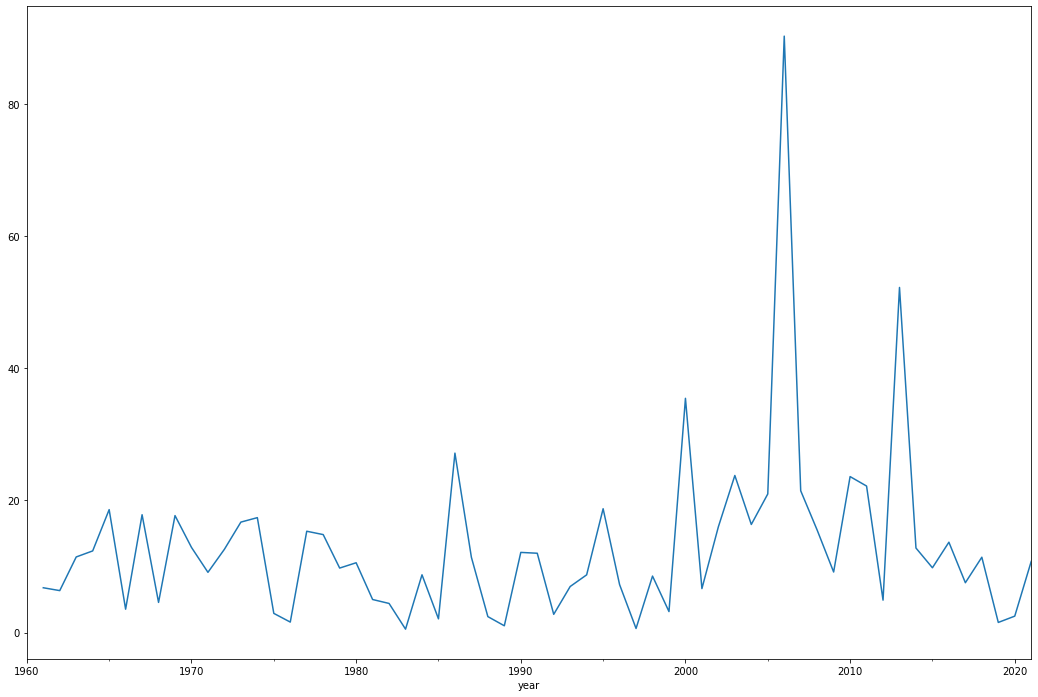

In [589]:
# Оценка волатильности данных
data['vol'] = data['GDP (current US$)'].pct_change(1).mul(100).abs()
data.head()

# Отображение графика волатильности
data['vol'].plot();

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


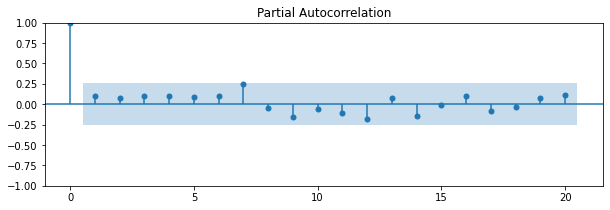

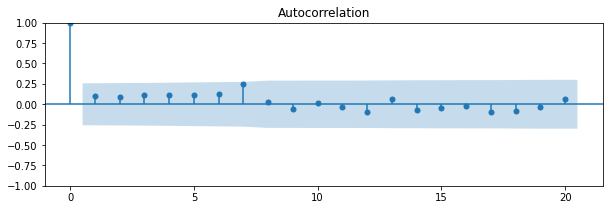

In [590]:
# Визуализация волатильности

train_df = data[:'2018-01-01']
test_df = data['2019-01-01':]

plt.rcParams['figure.figsize'] = 10, 3

sgt.plot_pacf(train_df['vol'][1:], lags=20)
sgt.plot_acf(train_df['vol'][1:], lags=20)
plt.show()

In [591]:
# Выполнение теста на стационарность
stat_test_8 = adfuller(train_df['vol'][1:])
print ('adf: ', stat_test_8[0])
print ('p-value: ', stat_test_8[1])
print ('Critical values: ', stat_test_8[4])
if stat_test_8[0]> stat_test_8[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -6.725311059553779
p-value:  3.4014596148856493e-09
Critical values:  {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
ряд стационарен


In [592]:
# Подготовка данных для использования модели GARCH
garch_df = pd.DataFrame(data['vol'].loc[data.index])
garch_df.loc[train_df.index, 'vol'] = train_df['vol'].dropna()
garch_df.tail(10)

,vol
year,
2012-01-01,4.915536
2013-01-01,52.220960
2014-01-01,12.798164
2015-01-01,9.813800
2016-01-01,13.679567
2017-01-01,7.551317
2018-01-01,11.410877
2019-01-01,1.542746
2020-01-01,2.495937


In [593]:
# Построение модели GARCH
model = arch_model(garch_df['vol'].dropna(), p=1, q=1, vol='GARCH')
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [594]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                    vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Fri, Nov 25 2022   Df Residuals:                       57
Time:                        11:59:45   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

In [595]:
# Предсказание по модели GARCH
predictions_df = test_df.copy()
predictions_df['Predictions'] = model_results.forecast().residual_variance.loc[test_df.index]

c:\Users\Пользователь\AppData\Local\Programs\Python\Python310\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [596]:
predictions_df

,GDP (current US$),vol,Predictions
year,,,
2019-01-01,6.833754e+10,1.542746,288.546011
2020-01-01,7.004320e+10,2.495937,292.216032
2021-01-01,7.759428e+10,10.780603,295.886053


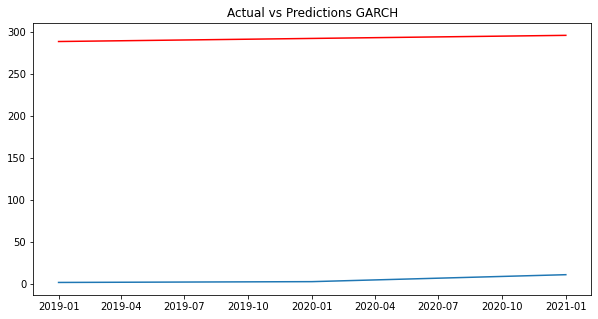

In [597]:
# Построение графиков предсказания и действительных значений на тестовой выборке
plt.rcParams['figure.figsize'] = 10, 5

plt.plot(predictions_df['vol'].abs())
plt.plot(predictions_df['Predictions'], color='red')

plt.title('Actual vs Predictions GARCH')
plt.show()

In [598]:
# Оценка ошибки модели GARCH
np.sqrt(mean_squared_error(predictions_df['vol'].abs(), predictions_df['Predictions']))

287.28251181405096

Text(0.5, 1.0, 'Actual vs Predictions LinearRegressions')

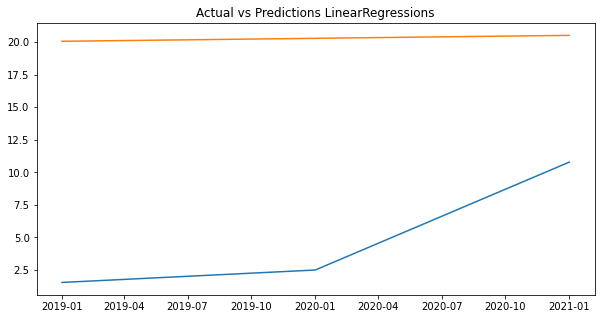

In [599]:
# Реализация модели линейной регрессии
X_train = pd.DataFrame(range(data['vol'].shape[0]))[:train_df.shape[0]].fillna(0)
X_test = pd.DataFrame(range(data['vol'].shape[0]))[train_df.shape[0]:].fillna(0)
y_train = train_df['vol'].fillna(0)
y_test = test_df['vol'].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.title('Actual vs Predictions LinearRegressions')

In [600]:
# Оценка ошибки модели lr
np.sqrt(mean_squared_error(predictions_df['vol'].abs(), lr_predict))

15.85588022673964

Вывод:

Результат получился странный. Модель GARCH показала результат хуже чем модель линейной регрессии (не исключаю ошибку, которую после долгих поисков так и не смог найти).
Судя по полученному графику, модель не уловила дисперсию, так как такое поведение было для неё новым и подобные случаи отсутствовали в обучающей выборке